In [152]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from kge.model import KgeModel
from kge.util.io import load_checkpoint
from sklearn.decomposition import PCA
from scipy.spatial.distance import cosine
from scipy.stats import pearsonr

np.random.seed(1)

In [32]:
# Load embeddings
model_path = '../../Chapter2/analysis/experiments/selfloops/simple/20230929-111630-simple_selfloops/00021/checkpoint_best.pt'
checkpoint = load_checkpoint(model_path)
data_path = '/Users/fu19841/Documents/thesis_analysis/kge/data/selfloops'
checkpoint['config'].set('dataset.name', data_path)
model = KgeModel.create_from(checkpoint)


# Get node info
node_embeds = model.state_dict()['_entity_embedder._embeddings.weight']
node_list = pd.read_csv(
    checkpoint['config'].get('dataset.name') + '/entity_ids.del', 
    sep='\t', header=None
)
node_name_to_index = {row[1]: row[0] for _, row in node_list.iterrows()}
node_index_to_name = {row[0]: row[1] for _, row in node_list.iterrows()}

# Get relation info
rel_embeds = model.state_dict()['_relation_embedder._embeddings.weight']
rel_list = pd.read_csv(
    checkpoint['config'].get('dataset.name') + '/relation_ids.del', 
    sep='\t', header=None
)
rel_name_to_index = {row[1]: row[0] for _, row in rel_list.iterrows()}
rel_index_to_name = {row[0]: row[1] for _, row in rel_list.iterrows()}

# Get list of drugs
drugs = [key for key in node_name_to_index.keys() if key.startswith('CID')]

# Load drug target edges
drug_target = pd.read_csv('/Users/fu19841/Documents/thesis_analysis/Chapter2/data/raw/bio-decagon-targets.csv')

Loading configuration of dataset /Users/fu19841/Documents/thesis_analysis/kge/data/selfloops from /Users/fu19841/Documents/thesis_analysis/kge/data/selfloops ...


In [3]:
def get_bipartite_neighbours(edgelist, drug):
    targets = edgelist.loc[edgelist['STITCH'] == drug].Gene.values
    neighbours = edgelist.query('Gene in @targets').STITCH.unique()
    neighbours = np.delete(neighbours, np.where(neighbours == drug))  # Remove self from neighbours
    return set(neighbours)

def mean_vec(mat):
    out_vec = []
    for i in range(len(mat[0])):
        mean_val = np.mean([vec[i] for vec in mat])
        out_vec.append(mean_val)
    return out_vec

def cosine_sim(u, v):
    return 1 - cosine(u, v)


# Ax=b -> Embedding * New Vec = Adjacency vec, solving to get X:

/Users/fu19841/miniconda3/envs/libkge/lib/python3.7/site-packages/ipykernel_launcher.py:52: FutureWarning:

`rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.



Found no neighbours for 372/645 nodes


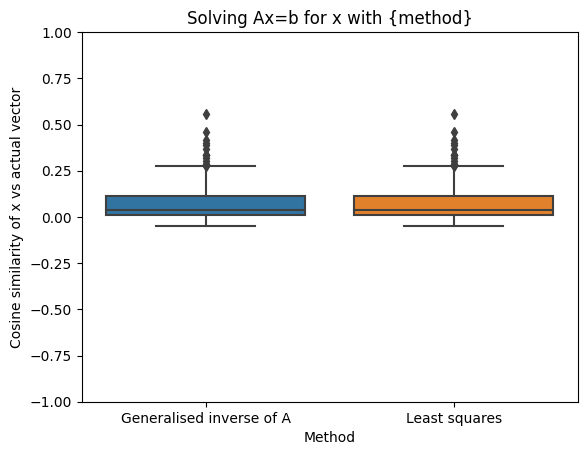

In [21]:
results = []
neighbourless = 0
for test_drug in drugs:

    # Get info of bipartite neighbour drugs (targeting the same genes)
    neighbour_nodes = get_bipartite_neighbours(drug_target, test_drug)
    n_neighbours = len(neighbour_nodes)
    if n_neighbours == 0:
        neighbourless += 1
        continue
    neighbours_index = [node_name_to_index[node] for node in neighbour_nodes]
    neighbours_embeds = node_embeds[neighbours_index]

    # Get test node info
    test_index = node_name_to_index[test_drug]
    test_embed = node_embeds[test_index]

    # Randomly select equal number of non-neighbour drugs
    all_strangers = set(drugs) - neighbour_nodes
    stranger_nodes = np.random.choice(list(all_strangers), n_neighbours, replace=False)
    strangers_index = [node_name_to_index[node] for node in stranger_nodes]
    strangers_embeds = node_embeds[strangers_index]

    # Combine all selected embeddings
    test_mat = torch.cat((neighbours_embeds, strangers_embeds))

    # Create adjacency vector to approximate with factorisation
    adj_vec = np.array([1 for _ in neighbour_nodes] + [0 for _ in stranger_nodes])


    #######################################
    # Solving Ax=b for x using generalised inverse of rectangular embeddings
    # Matrix test_mat is rectangular so have to take the generalised inverse to solve for my_vec..
    # .. where test_mat x my_vec = adj_vec
    rect_inverse = np.linalg.pinv(test_mat)  
    my_vec = np.dot(rect_inverse, adj_vec)

    # Measure error against desired adjacency
    adj_estimate = np.dot(my_vec, test_mat.T)
    neighbour_error = np.abs(1 - np.mean(adj_estimate[ :n_neighbours]))
    stranger_error = np.abs(0 - np.mean(adj_estimate[n_neighbours: ]))

    # Measure similarity to actual embedding
    similarity = cosine_sim(test_embed, my_vec)

    # Store result
    results.append(['Generalised inverse of A', test_drug, n_neighbours, neighbour_error, stranger_error, similarity])


    ######################################## 
    # Solving Ax=b for x using least squares
    my_vec = np.linalg.lstsq(test_mat, adj_vec)

    # Measure error against desired adjacency
    adj_estimate = np.dot(my_vec[0], test_mat.T)
    neighbour_error = np.abs(1 - np.mean(adj_estimate[ :n_neighbours]))
    stranger_error = np.abs(0 - np.mean(adj_estimate[n_neighbours: ]))

    # Measure similarity to actual embedding
    similarity = cosine_sim(test_embed, my_vec[0])
    # Store result
    results.append(['Least squares', test_drug, n_neighbours, neighbour_error, stranger_error, similarity])



print(f'Found no neighbours for {neighbourless}/{len(drugs)} nodes')

results = pd.DataFrame(results, columns=['Method', 'Drug', 'num_neighbors', 'neighbour error', 'stranger error', 'cosine_sim_to_actual'])

plt.clf()
sns.boxplot(data=results, x='Method', y='cosine_sim_to_actual')
plt.ylim((-1, 1))
plt.title('Solving Ax=b for x with {method}')
plt.ylabel('Cosine similarity of x vs actual vector')
plt.show()


These similarities are very low on average, and look to be identical to one another. Is the generalised inverse related to the projection done in least squares?

# Get x by aggregating information from neighbours:

Found no neighbours for 372/645 nodes


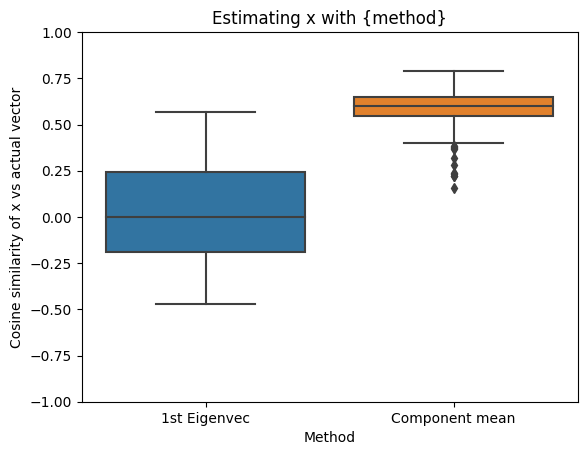

In [20]:
results = []
neighbourless = 0
for test_drug in drugs:

    # Get info of bipartite neighbour drugs (targeting the same genes)
    neighbour_nodes = get_bipartite_neighbours(drug_target, test_drug)
    n_neighbours = len(neighbour_nodes)
    if n_neighbours == 0:
        neighbourless += 1
        continue
    neighbours_index = [node_name_to_index[node] for node in neighbour_nodes]
    neighbours_embeds = node_embeds[neighbours_index]

    # Get test node info
    test_index = node_name_to_index[test_drug]
    test_embed = node_embeds[test_index]


    #######################################
    # Take principal eigenvec of neighbour embeddings
    if n_neighbours >= 2:
        my_vec = PCA().fit(neighbours_embeds).components_[1]
        similarity = cosine_sim(test_embed, my_vec)
        results.append(['1st Eigenvec', test_drug, n_neighbours, similarity])

    #######################################
    # Take component-wise mean of neighbour embeddings
    my_vec = mean_vec(neighbours_embeds)
    similarity = cosine_sim(test_embed, my_vec)
    results.append(['Component mean', test_drug, n_neighbours, similarity])



print(f'Found no neighbours for {neighbourless}/{len(drugs)} nodes')

results = pd.DataFrame(results, columns=['Method', 'Drug', 'num_neighbors', 'cosine_sim_to_actual'])

plt.clf()
sns.boxplot(data=results, x='Method', y='cosine_sim_to_actual')
plt.ylim((-1, 1))
plt.title('Estimating x with {method}')
plt.ylabel('Cosine similarity of x vs actual vector')
plt.show()

Taking the mean of the components of neighbouring vectors produces a surprisingly good estimate of the actual vector, while taking the principal eigenvector of the neighbouring vectors does not.

# Assess new vectors ability to score known side effect triples

In [100]:
# Load known triples
polySE_edges_raw = pd.read_csv('../../Chapter2/data/raw/bio-decagon-combo.csv')

# Filter out the ~400 ish edges excluded by Decagon
polySE_edges = polySE_edges_raw.merge(rel_list, left_on='Polypharmacy Side Effect', right_on=1)

In [58]:
def SimplEScorer(s_emb, p_emb, o_emb, combine: str):
    n = p_emb.size(0)

    # split left/right
    s_emb_h, s_emb_t = torch.chunk(s_emb, 2, dim=1)
    p_emb_forward, p_emb_backward = torch.chunk(p_emb, 2, dim=1)
    o_emb_h, o_emb_t = torch.chunk(o_emb, 2, dim=1)

    if combine == "spo":
        out1 = (s_emb_h * p_emb_forward * o_emb_t).sum(dim=1)
        out2 = (s_emb_t * p_emb_backward * o_emb_h).sum(dim=1)
    elif combine == "sp_":
        out1 = (s_emb_h * p_emb_forward).mm(o_emb_t.transpose(0, 1))
        out2 = (s_emb_t * p_emb_backward).mm(o_emb_h.transpose(0, 1))
    elif combine == "_po":
        out1 = (o_emb_t * p_emb_forward).mm(s_emb_h.transpose(0, 1))
        out2 = (o_emb_h * p_emb_backward).mm(s_emb_t.transpose(0, 1))
    else:
        return super().score_emb(s_emb, p_emb, o_emb, combine)

    return (out1 + out2).view(n, -1) / 2.0

In [157]:
n_samples = 1000
sample_edges = polySE_edges.loc[np.random.choice(polySE_edges.index, n_samples)]
results = []
n_dim = 256
for i, row in sample_edges.iterrows():
    # Get item info
    head = row['STITCH 1']
    tail = row['STITCH 2']
    rel = row['Polypharmacy Side Effect']

    # Load corresponding vectors
    h_vec = node_embeds[node_name_to_index[head]].reshape(1, n_dim)
    t_vec = node_embeds[node_name_to_index[tail]].reshape(1, n_dim)
    r_vec = rel_embeds[rel_name_to_index[rel]].reshape(1, n_dim)

    # Get actual score of triple
    actual_score = SimplEScorer(h_vec, r_vec, t_vec, combine='spo')[0].reshape((1))

    # Get neighbour vector info
    neighbour_nodes = get_bipartite_neighbours(drug_target, tail)
    n_neighbours = len(neighbour_nodes)
    if n_neighbours == 0:
        #print('No neighbours, skipping...')
        continue
    neighbours_index = [node_name_to_index[node] for node in neighbour_nodes]
    neighbours_embeds = node_embeds[neighbours_index]

    # Get score of triple using estimated vector
    t_vec_est = torch.tensor(mean_vec(neighbours_embeds)).reshape(1, n_dim)
    est_score = SimplEScorer(h_vec, r_vec, t_vec_est, combine='spo').reshape((1))

    # Save result
    results.append(
        [head, rel, tail, actual_score.item(), n_neighbours, est_score.item()]
    )
    
    
results = pd.DataFrame(
    results, 
    columns=['h', 'r', 't', 'score_actual', 'n_neighbours', 'score_est']
)
corr = pearsonr(results.score_actual, results.score_est)
print(f'Correlation between actual and estimate: {round(corr[0], 3)}')
results


No neighbours, skipping...
No neighbours, skipping...
No neighbours, skipping...
No neighbours, skipping...
No neighbours, skipping...
No neighbours, skipping...
No neighbours, skipping...
No neighbours, skipping...
No neighbours, skipping...
No neighbours, skipping...
No neighbours, skipping...
No neighbours, skipping...
No neighbours, skipping...
No neighbours, skipping...
No neighbours, skipping...
No neighbours, skipping...
No neighbours, skipping...
No neighbours, skipping...
No neighbours, skipping...
No neighbours, skipping...
No neighbours, skipping...
No neighbours, skipping...
No neighbours, skipping...
No neighbours, skipping...
No neighbours, skipping...
No neighbours, skipping...
No neighbours, skipping...
No neighbours, skipping...
No neighbours, skipping...
No neighbours, skipping...
No neighbours, skipping...
No neighbours, skipping...
No neighbours, skipping...
No neighbours, skipping...
No neighbours, skipping...
No neighbours, skipping...
No neighbours, skipping...
N

,h,r,t,score_actual,n_neighbours,score_est
0,CID000002806,C0017672,CID000004679,-0.136198,29,-4.751519
1,CID000002554,C0017168,CID000004205,-0.400934,166,-3.277564
2,CID000002160,C0011616,CID000005212,-1.106917,107,-6.183324
3,CID000003016,C0039231,CID000005078,-0.052699,137,-4.175130
4,CID000003345,C0006849,CID000005090,0.128189,152,-7.234436
...,...,...,...,...,...,...
447,CID000002520,C0020040,CID000004168,-0.260495,143,-3.898256
448,CID000004674,C0030193,CID000005732,0.367789,9,-23.543894
449,CID000001302,C0030193,CID000003957,0.412633,137,-1.450300
450,CID000002576,C0026764,CID000054454,-0.689198,32,-4.327364


TODO:
- Above loop is only testing estimated vectors as tails, need to try as head too
- Also, try the three other ways of estimating vectors
- The est scores seem to be on a way bigger scale than the actual scores. Investigate this, it shouldn't change the correlation but it would be good to fix